<a href="https://colab.research.google.com/github/pholpaphankorn/ml-stock-price-prediction/blob/main/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
%cd 'drive/MyDrive/Classroom/Machine Learning 2565-1/Project'

[Errno 2] No such file or directory: 'drive/MyDrive/Classroom/Machine Learning 2565-1/Project'
/content/drive/MyDrive/Classroom/Machine Learning 2565-1/Project


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
from scipy import stats,mean
import keras
from keras.models import Sequential
from keras.layers import Dropout,Dense,LSTM,Flatten
from keras.callbacks import EarlyStopping
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,r2_score
from keras_tuner import RandomSearch
import joblib

In [ ]:
def plotStockPrice(actual,predict,timestep,name):
  plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
  plt.plot(actual, color='red', label = 'Actual Closing Price')
  plt.plot(predict, color='green', label = 'Predicted Closing Price')
  plt.title(name+' Actual vs Predicted - Stock Closing Price '+timestep)
  plt.xlabel('Index')
  plt.ylabel('Stock Price')
  plt.legend(loc='best')
  plt.show()

  plt.figure(figsize=(8,4), dpi= 100, facecolor='w', edgecolor='k')
  plt.scatter(actual, predict)
  plt.xlabel("actual")
  plt.ylabel("predicted")
  plt.title(name+' Scatter plot - actual vs predicted '+timestep)
  plt.show()
def showResult(x_test,y_test,descript,model,timestep,name):
  pred=model.predict(x_test)
  r2_model_before_tuning=r2_score(np.array(y_test), pred)
  print('R2 score '+descript+':',r2_model_before_tuning)
  mse_model_before_tuning=mean_squared_error(np.array(y_test), pred)
  print('mean_squared_error '+descript+':',mse_model_before_tuning)

  plotStockPrice(np.array(y_test),pred,timestep,name)
  return pred,r2_model_before_tuning,mse_model_before_tuning

In [ ]:
def prepareDataForLR(x_df,y_df,return_period):
  y_df=y_df.shift(-return_period)
  y_df=y_df.iloc[:-(return_period) , :]
  x_df=x_df.iloc[:-(return_period) , :]
  return x_df,y_df

In [ ]:
n_steps=24
def prepareDataForLSTM(x_df,y_df,n_steps,return_period):
  x_df=np.array(x_df)
  y_df=np.array(y_df)
  x,y=[],[]
  for i in range(len(x_df)-n_steps-return_period+1):
    x.append(x_df[i:i+n_steps,:])
    y.append(y_df[(i+n_steps)+return_period-1,-1])
  x=np.array(x)
  y=np.array(y)
  return x,y


# ข้อมูลหุ้น Meta 2-4 พ.ย. 65

In [ ]:
x_test=pd.read_csv('x_df_test.csv')
y_test=pd.read_csv('y_df_test.csv')

In [ ]:

x_test.drop(['Unnamed: 0'], axis=1,inplace=True)
x_test

,stock_close,stock_volume,spy_close,spy_volume,overall_sentiment_score
0,-1.856947,-0.485026,0.607829,-0.609489,0.726702
1,-1.862836,-0.491651,0.604673,-0.618948,0.743402
2,-1.857437,-0.495648,0.617297,-0.623680,0.743402
3,-1.863327,-0.494190,0.629133,-0.618703,0.743402
4,-1.865291,-0.497252,0.617297,-0.610727,0.743402
...,...,...,...,...,...
523,-2.071438,-0.493728,-0.077044,-0.624992,-0.264481
524,-2.071929,-0.489831,-0.075466,-0.625192,-0.264481
525,-2.072905,-0.497403,-0.077833,-0.625360,-0.264481
526,-2.074874,-0.494690,-0.070732,-0.612320,-0.264481


In [ ]:

y_test.drop(['Unnamed: 0'], axis=1,inplace=True)
y_test

,stock_close
0,95.0900
1,94.9700
2,95.0800
3,94.9600
4,94.9200
...,...
523,90.7200
524,90.7100
525,90.6901
526,90.6500


# Split data to 10 chunks

In [ ]:
x_test_chunks=np.array_split(x_test, 10)
y_test_chunks=np.array_split(y_test, 10)

In [ ]:
x_test_chunks

[    stock_close  stock_volume  spy_close  spy_volume  overall_sentiment_score
 0     -1.856947     -0.485026   0.607829   -0.609489                 0.726702
 1     -1.862836     -0.491651   0.604673   -0.618948                 0.743402
 2     -1.857437     -0.495648   0.617297   -0.623680                 0.743402
 3     -1.863327     -0.494190   0.629133   -0.618703                 0.743402
 4     -1.865291     -0.497252   0.617297   -0.610727                 0.743402
 5     -1.861855     -0.495709   0.617297   -0.617737                 0.743402
 6     -1.856456     -0.494109   0.627555   -0.621601                 0.278603
 7     -1.860382     -0.496675   0.637023   -0.597167                 0.278603
 8     -1.859892     -0.494226   0.625187   -0.621546                 0.278603
 9     -1.863818     -0.494210   0.640968   -0.621908                 0.278603
 10    -1.866272     -0.490267   0.637023   -0.616864                 0.278603
 11    -1.871181     -0.474570   0.647280   -0.61915

In [ ]:
y_test_chunks

[    stock_close
 0       95.0900
 1       94.9700
 2       95.0800
 3       94.9600
 4       94.9200
 5       94.9900
 6       95.1000
 7       95.0200
 8       95.0300
 9       94.9500
 10      94.9000
 11      94.8000
 12      94.8000
 13      94.6000
 14      94.7400
 15      94.6000
 16      94.7000
 17      94.8000
 18      94.7087
 19      94.7600
 20      94.7200
 21      94.6500
 22      94.6600
 23      94.7200
 24      94.6500
 25      94.3400
 26      94.4500
 27      94.4000
 28      94.3400
 29      94.2200
 30      93.6800
 31      93.3476
 32      93.1400
 33      92.9200
 34      93.4851
 35      93.3950
 36      93.7500
 37      93.4350
 38      93.2110
 39      93.4550
 40      93.2300
 41      93.2265
 42      93.1400
 43      93.3472
 44      93.4820
 45      93.2299
 46      93.0570
 47      92.9586
 48      93.0500
 49      93.0700
 50      92.6491
 51      92.6950
 52      92.7700,      stock_close
 53       92.8500
 54       92.8400
 55       92.7600
 56       

# set return_period

In [ ]:
return_period=2

# Choose test sample

In [ ]:
num_test=3

In [ ]:
x_test_small=x_test_chunks[num_test]
y_test_small=y_test_chunks[num_test]

In [ ]:
x_test_small

,stock_close,stock_volume,spy_close,spy_volume,overall_sentiment_score
159,-2.053277,-0.497686,-0.131486,-0.623295,0.084241
160,-2.061130,-0.495299,-0.163047,-0.615005,0.084241
161,-2.066529,-0.497014,-0.196186,-0.618625,0.927174
162,-2.067511,-0.498101,-0.213545,-0.597177,0.927174
163,-2.064075,-0.496901,-0.215912,-0.623331,0.927174
164,-2.064075,-0.492004,-0.196975,-0.620618,0.927174
165,-2.071929,-0.495453,-0.204866,-0.624820,0.927174
166,-2.067511,-0.499763,-0.219068,-0.622964,0.927174
167,-2.062603,-0.496871,-0.179617,-0.616676,0.927174
168,-2.066039,-0.495660,-0.148056,-0.622107,0.927174


# Linear Regression

In [ ]:
x_lr_test,y_lr_test=prepareDataForLR(x_test_small,y_test_small,return_period)
x_lr_test=x_lr_test.iloc[23:]
y_lr_test=y_lr_test.iloc[23:]

In [ ]:
y_lr_test

,stock_close
182,90.3100
183,90.3200
184,90.3200
185,90.5000
186,90.4000
187,90.3800
188,90.4000
189,90.3800
190,90.5000
191,90.4300


In [ ]:
lr_model = joblib.load('best_lr.sav')

In [ ]:
lr_model.get_params()

{'copy_X': True,
 'fit_intercept': True,
 'n_jobs': None,
 'normalize': True,
 'positive': True}

R2 score after tuning: -0.35578427036921023
mean_squared_error after tuning: 0.030267934798954538


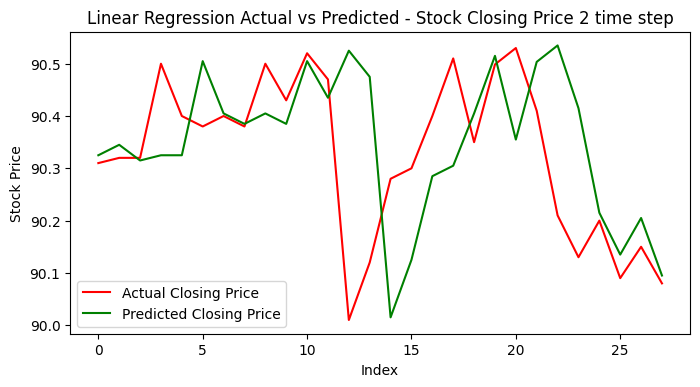

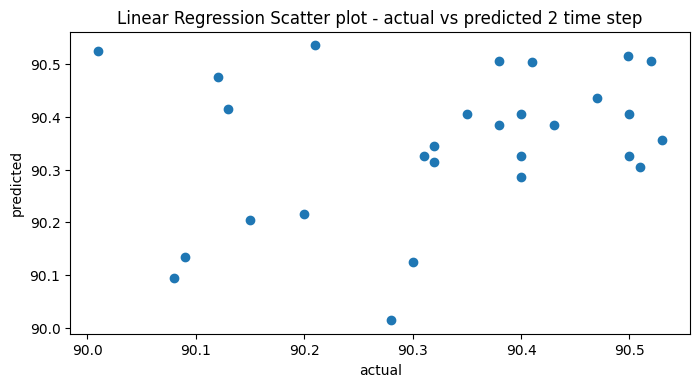

In [ ]:
lr_pred_1,r2_lr_best_1,mse_lr_best_1=showResult(x_lr_test,y_lr_test,'after tuning',lr_model,str(return_period)+' time step','Linear Regression')

# LSTM

In [ ]:
x_lstm_test,y_lstm_test=prepareDataForLSTM(x_test_small,y_test_small,n_steps,return_period)

In [ ]:
lstm_model=keras.models.load_model('checkpoint_lstm_full_trained')

In [ ]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 24)            2880      
                                                                 
 dropout (Dropout)           (None, 24, 24)            0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 18)            3096      
                                                                 
 dropout_1 (Dropout)         (None, 24, 18)            0         
                                                                 
 lstm_2 (LSTM)               (None, 24, 12)            1488      
                                                                 
 dropout_2 (Dropout)         (None, 24, 12)            0         
                                                                 
 lstm_3 (LSTM)               (None, 18)                2

In [ ]:
y_lstm_test

array([90.31  , 90.32  , 90.32  , 90.5   , 90.4   , 90.38  , 90.4   ,
       90.38  , 90.5   , 90.43  , 90.52  , 90.47  , 90.01  , 90.12  ,
       90.28  , 90.3   , 90.4   , 90.5101, 90.35  , 90.4986, 90.53  ,
       90.41  , 90.21  , 90.13  , 90.2   , 90.09  , 90.15  , 90.08  ])

1/1 [==============================] - 2s 2s/step
R2 score after tuning: -453.43684337378176
mean_squared_error after tuning: 10.145319610275893


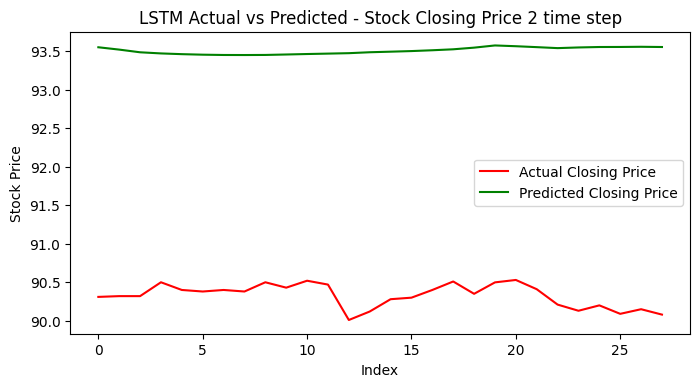

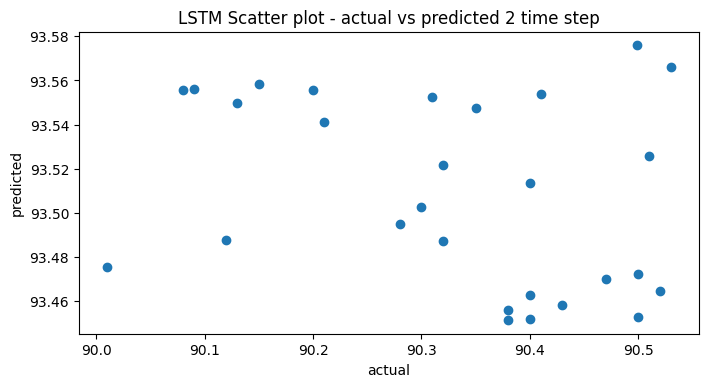

In [ ]:
lstm_pred_1,r2_lstm_best_1,mse_lstm_best_1=showResult(x_lstm_test,y_lstm_test,'after tuning',lstm_model,str(return_period)+' time step','LSTM')

In [ ]:
model_R2=[r2_lr_best_1,r2_lstm_best_1]
model_MSE=[mse_lr_best_1,mse_lstm_best_1]

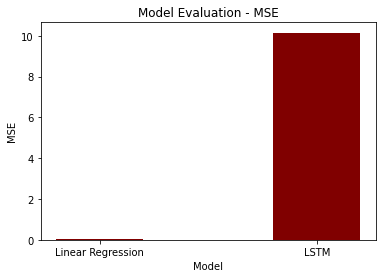

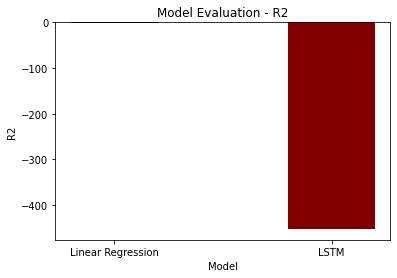

In [ ]:
model_label=["Linear Regression","LSTM"]
metrics_label=['MSE','R2']
metrics=[model_MSE,model_R2]
for i in range(len(metrics)):
  # creating the bar plot
  plt.bar(model_label, metrics[i], color ='maroon',width = 0.4)
 
  plt.xlabel("Model")
  plt.ylabel(metrics_label[i])
  plt.title('Model Evaluation - '+metrics_label[i])
  plt.show()